# Lie Detection Based on Facial Expression and Body Posture

> Mayur Sharma<br>
> Khushi Tulsian<br>
> Rohan deep Kujur<br>

In [1]:
import mediapipe as mp
import cv2
from math import inf
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

mp_holistic = mp.solutions.holistic
holistic    = mp_holistic.Holistic()
mp_drawing  = mp.solutions.drawing_utils

In [2]:
# eyebrow                     x2
# face left right top bottom  x4
# lips                        x1
# body                        x8
# =15 columns     x and y     = 30 features

columns0 = ['lips', 'left_brow', 'right_brow'] + [f"body{i}" for i in range(8)] + [f"face{i}" for i in range(4)] 
columns  = list()
for col in columns0:
    columns.append(col+'x')
    columns.append(col+'y')
columns.append('TRUTH')
TRAINING_FEATURES = pd.DataFrame(columns=columns)
TESTING_FEATURES  = pd.DataFrame(columns=columns)

LANDMARKS_LOC = {
    'left_brow'  : [107, 66, 105, 63, 70, 46,53,52,65,55],
    'right_brow' : [336, 285, 296, 295, 334, 282, 293, 283, 276, 300],
    'lips'       : [78, 308, 80, 88, 82, 87, 312, 317, 310, 318],
    'face0'      : [54,68,103,104,108,69,67,10,151,338,337,397,333,332,298,284,251,301,21,71,109,297,299],                                                                       #forehead
    'face1'      : [18, 32, 83, 140, 148, 152, 171, 175, 176, 199, 200, 201, 208, 262, 313, 369, 377, 396, 400, 421, 428],                                                       #chin
    'face2'      : [36, 50, 58, 93, 101, 111, 116, 117, 118, 123, 132, 137, 138, 147, 172, 177, 186, 187, 192, 203, 205, 206, 207, 212, 213, 214, 215, 216, 227, 228, 234],      #left_face
    'face3'      : [266, 280, 288, 323, 330, 340, 345, 346, 347, 352, 361, 366, 367, 376, 397, 401, 410, 411, 416, 423, 425, 426, 427, 432, 433, 434, 435, 436, 447, 448, 454]   #right_face
}

#video intervals where the subject answers
INTERVALS = [
    [90,  140, 1],
    [170, 220, 1],
    [250, 340, 0],
    [370, 450, 1],
    [480, 540, 1],    #TESTING INTERVAL
    [600, 660, 0],
    [inf, inf, 0]]

TEST_INTERVAL = 3

TRAINING_FEATURES

,lipsx,lipsy,left_browx,left_browy,right_browx,right_browy,body0x,body0y,body1x,body1y,...,body7y,face0x,face0y,face1x,face1y,face2x,face2y,face3x,face3y,TRUTH


In [3]:
def draw_holistics(image, results):
    mp_drawing.draw_landmarks( frame,
        results.face_landmarks,
        mp_holistic.FACEMESH_CONTOURS,
        mp_drawing.DrawingSpec(
            color=(255,0,255),
            thickness=1,
            circle_radius=1),
        
        mp_drawing.DrawingSpec(
            color=(255,255,255),
            thickness=1,
            circle_radius=1)
        )
    
    mp_drawing.draw_landmarks(
        frame,
        results.pose_landmarks,
        mp_holistic.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(
            color=(0,230,255),
            thickness=2,
            circle_radius=1),
        
        mp_drawing.DrawingSpec(
            color=(255,255,255),
            thickness=1,
            circle_radius=1)
        )

def extract_facial_features(landmarks):
    nose = landmarks[4]  #nose at index 4
    #x, y = get_cordinates(nose, DIMS)
    #cv2.circle(frame, (x, y), 2, (0,0,0), 1)
    features = dict()
    
    for feature in LANDMARKS_LOC:
        feature_loc = np.array([0,0], dtype=np.float64)
    
        for idx in LANDMARKS_LOC[feature]:
            mark = landmarks[idx]
            feature_loc += np.array( [mark.x, mark.y] )
        feature_loc /= len(LANDMARKS_LOC[feature])           #average feature location
        
        result = feature_loc - np.array([nose.x, nose.y])    #normailze
        features[feature+'x'] = result[0]
        features[feature+'y'] = result[1]
    
    return features

def extract_body_features(landmarks):
    chest = [(landmarks[11].x + landmarks[12].x)/2, (landmarks[11].y + landmarks[12].y)/2]
    i = 0
    features = dict()
    
    for idx in range(11,19):
        mark = landmarks[idx]
        features[f'body{i}x'] = mark.x - chest[0]
        features[f'body{i}y'] = mark.y - chest[1]
        i += 1
    
    return features

In [4]:
video = cv2.VideoCapture('.\Train_video.mp4')
DIMS  = np.array([500, 880], dtype=int)      #Video crop dimension to subject
SCALE = 0.75

TRAINING_FEATURES.drop(TRAINING_FEATURES.index, inplace=True)
TESTING_FEATURES.drop(TESTING_FEATURES.index, inplace=True)

frame_no = 0
curr_interval  = 0

while(1):
    #reading video data
    success, frame = video.read()
    if not success: break
    #if frame_no == 90: break     #Testing
    
    #resizing and cropping
    frame = frame[300:300+DIMS[1], 150:150+DIMS[0]]
    frame = cv2.resize(frame, (0, 0), fx = SCALE, fy = SCALE)

    if INTERVALS[curr_interval][0] <= frame_no <= INTERVALS[curr_interval][1]:
        #processing body features
        results = holistic.process( cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) )
        draw_holistics(frame, results)

        face_features = extract_facial_features(results.face_landmarks.landmark)
        body_features = extract_body_features(results.pose_landmarks.landmark)
        #print(face_features)
        #print(len(body_features) + len(face_features))

        features = {"TRUTH" : INTERVALS[curr_interval][2]}
        features.update(face_features)
        features.update(body_features)
        
        #Testing interval for our code
        if curr_interval != TEST_INTERVAL:
            TRAINING_FEATURES = TRAINING_FEATURES.append([features])
        else:
            TESTING_FEATURES = TESTING_FEATURES.append([features])
        
        if frame_no > INTERVALS[curr_interval][1]-1:
            curr_interval += 1
    
    #display results
    cv2.imshow("Frame", frame)
    cv2.waitKey(1)
    frame_no += 1

cv2.destroyAllWindows()
video.release()

In [5]:
f1 = pd.DataFrame([[1,2,3,4,5]])
f2 = pd.DataFrame([[1,2,3,4,5]])

pd.concat([f1, f2])

,0,1,2,3,4
0,1,2,3,4,5
0,1,2,3,4,5


In [10]:
TRAINING_FEATURES["TRUTH"] = pd.to_numeric(TRAINING_FEATURES["TRUTH"])
TRAINING_FEATURES

#TRAINING_FEATURES.to_csv("lie_dataset.csv", index=False)

,lipsx,lipsy,left_browx,left_browy,right_browx,right_browy,body0x,body0y,body1x,body1y,...,body7y,face0x,face0y,face1x,face1y,face2x,face2y,face3x,face3y,TRUTH
0,-0.001107,0.031804,-0.053075,-0.033591,0.060648,-0.02937,0.244749,-0.003385,-0.244749,0.003385,...,0.544281,0.008663,-0.040341,-0.004295,0.063091,-0.080905,0.017946,0.079827,0.023363,1
0,-0.001794,0.030796,-0.052959,-0.032074,0.059244,-0.029025,0.246057,-0.003136,-0.246057,0.003136,...,0.544409,0.007592,-0.037885,-0.004266,0.061061,-0.079106,0.019367,0.077311,0.023393,1
0,-0.002718,0.031074,-0.054027,-0.032401,0.058203,-0.028548,0.246974,-0.002954,-0.246974,0.002954,...,0.545489,0.006395,-0.037179,-0.006021,0.060508,-0.081213,0.019012,0.075062,0.023403,1
0,-0.002734,0.031018,-0.053086,-0.032754,0.059224,-0.028536,0.247235,-0.002925,-0.247235,0.002925,...,0.545792,0.007735,-0.037539,-0.006494,0.060074,-0.080609,0.018408,0.075682,0.023359,1
0,-0.002798,0.030957,-0.052412,-0.032349,0.058886,-0.028198,0.247395,-0.002847,-0.247395,0.002847,...,0.545749,0.007852,-0.037106,-0.006559,0.060057,-0.080242,0.018465,0.075385,0.023527,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-0.004064,0.030367,-0.051459,-0.036093,0.063545,-0.029463,0.257691,-0.005228,-0.257691,0.005228,...,0.549731,0.011345,-0.040173,-0.009582,0.060357,-0.082531,0.015288,0.077223,0.023512,0
0,-0.004863,0.030124,-0.052151,-0.036825,0.062502,-0.02984,0.257625,-0.005421,-0.257625,0.005421,...,0.549924,0.010094,-0.040794,-0.010609,0.059878,-0.083668,0.01426,0.075116,0.02286,0
0,-0.004897,0.030203,-0.052408,-0.037538,0.062197,-0.030614,0.257519,-0.005588,-0.257519,0.005588,...,0.550705,0.009799,-0.041608,-0.010408,0.059689,-0.083528,0.013633,0.075071,0.02203,0
0,-0.00499,0.030032,-0.052824,-0.038006,0.061903,-0.03109,0.257319,-0.005752,-0.257319,0.005752,...,0.552645,0.009415,-0.042397,-0.010559,0.059199,-0.084124,0.012876,0.074882,0.021163,0


In [7]:
from sklearn.linear_model import LogisticRegression

TRAINING_Y = TRAINING_FEATURES["TRUTH"]
TRAINING_X = TRAINING_FEATURES.drop("TRUTH", axis=1)

TESTING_Y = TESTING_FEATURES["TRUTH"]
TESTING_X = TESTING_FEATURES.drop("TRUTH", axis=1)

logr = LogisticRegression(random_state=16)
logr = logr.fit(TRAINING_X, TRAINING_Y)
print(TRAINING_Y.shape)

(315,)


In [8]:
y_pred = logr.predict(TESTING_X)
print(f"Expected output: {INTERVALS[TEST_INTERVAL][2]}")
print("Prediction:\n", y_pred)

Expected output: 1
Prediction:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]


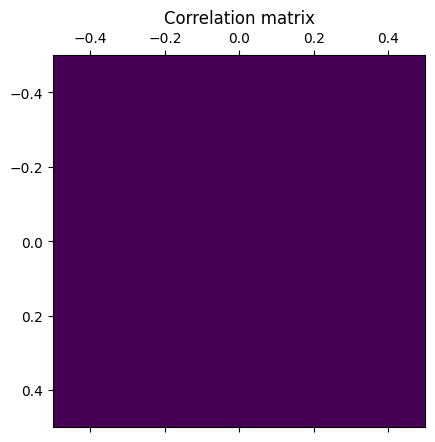

In [9]:
import matplotlib.pyplot as plt
type(TRAINING_FEATURES.corr())

plt.matshow(TRAINING_FEATURES.corr())
plt.title("Correlation matrix")
plt.show()

## Conclusion

The predicted values match the actual values, hence our model works successfully!

### Extra Notes
1) FACE MESH: **landmarks index 4** is the tip of the nose used for normalisation